In [2]:
# ============================================
# Load python scripts
# ============================================
import sys
sys.path.append('/kaggle/input/meansparse')
import Meansparse_wrn_94_16

In [3]:
# ============================================
# Install dependencies
# ============================================
!pip install -q huggingface_hub captum

In [19]:
# ============================================
# Import libraries
# ============================================
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset, Subset, WeightedRandomSampler
from torchsummary import summary
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from PIL import ImageFile, Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import gc
from huggingface_hub import HfApi, login, create_repo, hf_hub_download
from kaggle_secrets import UserSecretsClient
import Meansparse_wrn_94_16
from Meansparse_wrn_94_16 import MeanSparse_DMWideResNet
import json
from torch.utils.data import Dataset
from captum.attr import Saliency, DeepLift, IntegratedGradients, Occlusion
import torchvision.transforms.functional as F

In [5]:
os.makedirs("/kaggle/working/xAI", exist_ok=True)
%cd /kaggle/working/xAI

/kaggle/working/xAI


In [6]:
# ---------------------------
# Setup
# ---------------------------
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)

# Root paths
data_root = "/kaggle/input/fracatlas"
write_dir = "/kaggle/working/fracatlas"
class_names = ["fractured", "not fractured"]

In [7]:
# Clean and recreate output directories
shutil.rmtree(write_dir, ignore_errors=True)
for cls in class_names:
    os.makedirs(os.path.join(write_dir, cls, "img"), exist_ok=True)
    os.makedirs(os.path.join(write_dir, cls, "ann"), exist_ok=True)

# ---------------------------
# Collect fractured images + annotations from train/test/val
# ---------------------------
fractured_imgs, fractured_anns = [], []
for subdir in ["train", "test", "val"]:
    img_dir = os.path.join(data_root, subdir, "img")
    ann_dir = os.path.join(data_root, subdir, "ann")
    if os.path.exists(img_dir):
        fractured_imgs.extend([os.path.join(img_dir, x) for x in os.listdir(img_dir)])
    if os.path.exists(ann_dir):
        fractured_anns.extend([os.path.join(ann_dir, x) for x in os.listdir(ann_dir)])

print(f"Found {len(fractured_imgs)} fractured images and {len(fractured_anns)} fractured annotations")

# ---------------------------
# Collect non-fractured images + annotations
# ---------------------------
nonfractured_imgs, nonfractured_anns = [], []
nf_img_dir = os.path.join(data_root, "not fractured", "img")
nf_ann_dir = os.path.join(data_root, "not fractured", "ann")

if os.path.exists(nf_img_dir):
    nonfractured_imgs = [os.path.join(nf_img_dir, x) for x in os.listdir(nf_img_dir)]
if os.path.exists(nf_ann_dir):
    nonfractured_anns = [os.path.join(nf_ann_dir, x) for x in os.listdir(nf_ann_dir)]

print(f"Found {len(nonfractured_imgs)} non-fractured images and {len(nonfractured_anns)} non-fractured annotations")

# ---------------------------
# Optional undersampling for non-fractured
# ---------------------------
target_nonfractured = 1500
if len(nonfractured_imgs) > target_nonfractured:
    selected_imgs = random.sample(nonfractured_imgs, target_nonfractured)
    selected_img_names = set(os.path.basename(x) for x in selected_imgs)
    nonfractured_anns = [x for x in nonfractured_anns if os.path.basename(x).replace('.json', '.png') in selected_img_names]
    nonfractured_imgs = selected_imgs

print(f"Using {len(nonfractured_imgs)} non-fractured images after undersampling.")

# ---------------------------
# Copy fractured data
# ---------------------------
for img_path in fractured_imgs:
    shutil.copy(img_path, os.path.join(write_dir, "fractured", "img"))
# Copy corresponding annotations (if exists)
for ann_path in fractured_anns:
    shutil.copy(ann_path, os.path.join(write_dir, "fractured", "ann"))

# ---------------------------
# Copy non-fractured data
# ---------------------------
for img_path in nonfractured_imgs:
    shutil.copy(img_path, os.path.join(write_dir, "not fractured", "img"))
# Copy corresponding annotations (if exists)
for ann_path in nonfractured_anns:
    shutil.copy(ann_path, os.path.join(write_dir, "not fractured", "ann"))

# ---------------------------
# Final check
# ---------------------------
print("✅ Dataset prepared successfully!")
for cls in class_names:
    n_img = len(os.listdir(os.path.join(write_dir, cls, "img")))
    n_ann = len(os.listdir(os.path.join(write_dir, cls, "ann")))
    print(f"{cls:15s}: {n_img} images | {n_ann} annotations")

Found 717 fractured images and 717 fractured annotations
Found 3366 non-fractured images and 3366 non-fractured annotations
Using 1500 non-fractured images after undersampling.
✅ Dataset prepared successfully!
fractured      : 717 images | 717 annotations
not fractured  : 1500 images | 0 annotations


In [8]:
# ---------------------------
# Transforms
# ---------------------------
# Standard normalization
normalize_transform = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2470, 0.2435, 0.2616]
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize_transform
])

In [9]:
class FracturedDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        ann_path = os.path.join(self.ann_dir, os.path.splitext(img_name)[0] + ".jpg.json")

        # Load image
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        # Load annotation
        with open(ann_path, "r") as f:
            ann = json.load(f)

        # Get rectangle coordinates
        rects = []
        for obj in ann.get("objects", []):
            if obj.get("geometryType") == "rectangle":
                (x1, y1), (x2, y2) = obj["points"]["exterior"]
                rects.append([x1, y1, x2, y2])

        # Compute scale factors
        new_w, new_h = 224, 224
        scale_x, scale_y = new_w / orig_w, new_h / orig_h

        # Scale the boxes
        scaled_rects = []
        for x1, y1, x2, y2 in rects:
            scaled_rects.append([
                x1 * scale_x,
                y1 * scale_y,
                x2 * scale_x,
                y2 * scale_y
            ])

        if self.transform:
            image = self.transform(image)

        return image, scaled_rects, img_name

In [10]:
# Recreate the model structure exactly as during training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MeanSparse_DMWideResNet(
    num_classes=2,
    depth=94,
    width=16,
    activation_fn=nn.SiLU,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2471, 0.2435, 0.2616)
)

# Freeze backbone and rebuild the classifier head (must match training)
for name, param in model.named_parameters():
    if not name.startswith("logits"):
        param.requires_grad = False

in_features = model.logits.in_features
model.logits = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

# Load trained weights
checkpoint_path = hf_hub_download(
    repo_id="MohammadFazli/xAI-fracture-xray-model",
    filename="best_meansparse_v2.pth"
)
model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=True)

model = model.to(device)
model.eval()

print("✅ Model successfully loaded and ready for inference.")

best_meansparse_v2.pth:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

✅ Model successfully loaded and ready for inference.


In [11]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
def show_saliency_with_box(model, dataset, idx, device='cuda'):
    model.eval()
    image, boxes, name = dataset[idx]
    image = image.unsqueeze(0).to(device).requires_grad_(True)

    # Forward
    output = model(image)
    pred_class = output.argmax(dim=1)

    # Compute saliency
    score = output[0, pred_class]
    score.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    # Convert normalized tensor back to image for visualization
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])],
        std=[1/s for s in [0.2470, 0.2435, 0.2616]]
    )

    img_vis = inv_normalize(image.squeeze().detach().cpu())
    img_vis = torch.clamp(img_vis, 0, 1).permute(1, 2, 0).detach().numpy()
    
    # Plot image + saliency
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img_vis)
    for (x1, y1, x2, y2) in boxes:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax[0].add_patch(rect)
    ax[0].set_title(f"Fracture Localization\n{name}")

    ax[1].imshow(saliency, cmap='hot')
    ax[1].set_title("Saliency Map")
    plt.show()

In [ ]:
dataset = FracturedDataset(
    img_dir="/kaggle/working/fracatlas/fractured/img",
    ann_dir="/kaggle/working/fracatlas/fractured/ann",
    transform=transform
)

# Example: visualize saliency + fracture box
show_saliency_with_box(model, dataset, idx=15, device='cuda')

In [23]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [12]:
dataset = FracturedDataset(
    img_dir="/kaggle/working/fracatlas/fractured/img",
    ann_dir="/kaggle/working/fracatlas/fractured/ann",
    transform=transform
)

# Evaluate on a subset of dataset
subset_indices = list(range(10))
subset_dataset = Subset(dataset, subset_indices)

In [20]:
def compute_saliency_map(image, model, target_class):
    """Compute saliency map (gradient-based)."""
    image.requires_grad = True
    output = model(image)
    score = output[0, target_class]
    if image.grad is not None:
        image.grad.zero_()
    score.backward()
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    return saliency.squeeze().detach().cpu().numpy()


def compute_integrated_gradients(image, model, target_class, steps=10):
    """
    Compute Integrated Gradients map with TILE-BASED processing.
    This splits the image into smaller tiles to reduce memory usage.
    """
    device = image.device
    _, _, h, w = image.shape
    
    # Process image in tiles to reduce memory
    tile_size = 112  # Half of 224 - adjust based on your GPU memory
    stride = tile_size  # No overlap for simplicity
    
    # Initialize full saliency map
    full_saliency = np.zeros((h, w), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)
    
    # Process each tile
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            y_end = min(y + tile_size, h)
            x_end = min(x + tile_size, w)
            
            # Extract tile
            tile = image[:, :, y:y_end, x:x_end].detach().clone().requires_grad_(True)
            
            # Skip if tile is too small
            if tile.shape[2] < 32 or tile.shape[3] < 32:
                continue
            
            try:
                # Create IG instance per tile
                ig = IntegratedGradients(model)
                
                with torch.set_grad_enabled(True):
                    # Use a zero baseline
                    baseline = torch.zeros_like(tile)
                    attributions, _ = ig.attribute(
                        tile,
                        baselines=baseline,
                        target=target_class,
                        n_steps=steps,
                        return_convergence_delta=True,
                        internal_batch_size=1
                    )
                
                # Get max across channels
                tile_saliency, _ = torch.max(attributions.abs(), dim=1)
                tile_result = tile_saliency.squeeze().detach().cpu().numpy()
                
                # Add to full map
                full_saliency[y:y_end, x:x_end] += tile_result
                count_map[y:y_end, x:x_end] += 1
                
                # Aggressive cleanup
                del ig, attributions, tile_saliency, tile, baseline
                torch.cuda.empty_cache()
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"OOM on tile ({y}:{y_end}, {x}:{x_end}), skipping...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
    
    # Average overlapping regions (if any)
    count_map[count_map == 0] = 1  # Avoid division by zero
    full_saliency = full_saliency / count_map
    
    return full_saliency


def compute_deeplift(image, model, target_class):
    """
    Compute DeepLift map with TILE-BASED processing to handle memory constraints.
    This splits the image into smaller tiles to reduce memory usage.
    """
    import warnings
    
    device = image.device
    _, _, h, w = image.shape
    
    # Process image in tiles to reduce memory
    tile_size = 112  # Half of 224 - adjust based on your GPU memory
    stride = tile_size  # No overlap for simplicity
    
    # Initialize full saliency map
    full_saliency = np.zeros((h, w), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)
    
    # Suppress Captum warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning, module='captum')
        
        # Process each tile
        for y in range(0, h, stride):
            for x in range(0, w, stride):
                y_end = min(y + tile_size, h)
                x_end = min(x + tile_size, w)
                
                # Extract tile
                tile = image[:, :, y:y_end, x:x_end].detach().clone()
                
                # Skip if tile is too small
                if tile.shape[2] < 32 or tile.shape[3] < 32:
                    continue
                
                try:
                    # Create DeepLift instance per tile to avoid memory accumulation
                    dl = DeepLift(model)
                    
                    with torch.set_grad_enabled(True):
                        # Use a zero baseline
                        baseline = torch.zeros_like(tile)
                        attributions = dl.attribute(tile, baselines=baseline, target=target_class)
                    
                    # Get max across channels
                    tile_saliency, _ = torch.max(attributions.abs(), dim=1)
                    tile_result = tile_saliency.squeeze().detach().cpu().numpy()
                    
                    # Add to full map
                    full_saliency[y:y_end, x:x_end] += tile_result
                    count_map[y:y_end, x:x_end] += 1
                    
                    # Aggressive cleanup
                    del dl, attributions, tile_saliency, tile, baseline
                    torch.cuda.empty_cache()
                    
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"OOM on tile ({y}:{y_end}, {x}:{x_end}), skipping...")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e
    
    # Average overlapping regions (if any)
    count_map[count_map == 0] = 1  # Avoid division by zero
    full_saliency = full_saliency / count_map
    
    return full_saliency


def compute_deeplift_simple(image, model, target_class):
    """
    Simplified DeepLift with maximum memory efficiency.
    Use this if tile-based approach still has issues.
    """
    # Move to CPU if GPU has issues
    device = image.device
    
    # Detach and use zero baseline
    image_input = image.detach().clone()
    baseline = torch.zeros_like(image_input)
    
    try:
        dl = DeepLift(model)
        
        with torch.set_grad_enabled(True):
            attributions = dl.attribute(image_input, baselines=baseline, target=target_class)
        
        # Convert to numpy immediately
        saliency, _ = torch.max(attributions.abs(), dim=1)
        result = saliency.squeeze().detach().cpu().numpy()
        
        # Clean up
        del attributions, saliency, image_input, baseline, dl
        torch.cuda.empty_cache()
        gc.collect()
        
        return result
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print("DeepLift OOM even on CPU - image might be too large")
            # Return zeros as fallback
            return np.zeros(image.shape[2:], dtype=np.float32)
        else:
            raise e


def compute_occlusion(image, model, target_class, sliding_window=15, stride=8):
    """
    Compute Occlusion attribution map using Captum.
    Uses sliding window occlusion over the image.
    """
    device = image.device
    try:
        occlusion = Occlusion(model)

        with torch.set_grad_enabled(True):
            # Define window shape same as image channels
            attributions = occlusion.attribute(
                image,
                strides=(3, stride, stride),
                target=target_class,
                sliding_window_shapes=(3, sliding_window, sliding_window),
                baselines=0
            )

        saliency, _ = torch.max(attributions.abs(), dim=1)
        result = saliency.squeeze().detach().cpu().numpy()

        del occlusion, attributions, saliency
        torch.cuda.empty_cache()
        gc.collect()

        return result

    except RuntimeError as e:
        if "out of memory" in str(e):
            print("Occlusion OOM - try smaller sliding_window or stride.")
            return np.zeros(image.shape[2:], dtype=np.float32)
        else:
            raise e

def compute_point_coverage(model, dataset, method='saliency', device='cuda', percentiles=[5, 15, 25, 50, 75, 85, 95],
                          use_tile_deeplift=True):
    """
    Compute only Point Coverage metric for a chosen attribution method.
    
    Args:
        model: PyTorch model
        dataset: dataset with (image, boxes, img_name)
        method: 'saliency', 'integrated_gradients', or 'deeplift'
        device: device to run on
        percentiles: list of percentile thresholds for saliency
        use_tile_deeplift: if True, use tile-based DeepLift (recommended for memory)
    """
    model.eval()

    attribution_methods = {
        'saliency': compute_saliency_map,
        'integrated_gradients': compute_integrated_gradients,
        'deeplift': compute_deeplift if use_tile_deeplift else compute_deeplift_simple,
        'occlusion': compute_occlusion
    }

    # Use GPU for all methods now
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if method not in attribution_methods:
        raise ValueError(f"Invalid method '{method}'. Choose from {list(attribution_methods.keys())}.")

    coverage_results = {p: [] for p in percentiles}

    pbar = tqdm(range(len(dataset)), desc=f"Computing Point Coverage ({method})")

    for idx in pbar:
        image, boxes, img_name = dataset[idx]
        image = image.unsqueeze(0).to(device)

        # Use no_grad for forward pass
        with torch.no_grad():
            output = model(image)
            pred_class = output.argmax(dim=1).item()

        # Create ground-truth mask
        gt_mask = np.zeros(image.shape[2:], dtype=np.uint8)
        for (x1, y1, x2, y2) in boxes:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(gt_mask.shape[1], x2), min(gt_mask.shape[0], y2)
            gt_mask[y1:y2, x1:x2] = 1
        if np.sum(gt_mask) == 0:
            continue

        # Compute chosen attribution map
        func = attribution_methods[method]
        try:
            # For saliency, we need a fresh clone with gradients
            if method == 'saliency':
                input_img = image.clone().requires_grad_(True)
            else:
                input_img = image
                
            saliency = func(input_img, model, pred_class)
            
            # Clear gradients immediately after attribution
            if hasattr(input_img, 'grad') and input_img.grad is not None:
                input_img.grad = None
            del input_img
            
        except Exception as e:
            print(f"[{method}] failed for {img_name}: {e}")
            continue

        # Evaluate point coverage at each percentile
        for percentile in percentiles:
            threshold = np.percentile(saliency, 100 - percentile)
            saliency_mask = (saliency >= threshold).astype(np.uint8)

            intersection_points = np.sum((gt_mask == 1) & (saliency_mask == 1))
            total_gt_points = np.sum(gt_mask)
            point_coverage = intersection_points / total_gt_points if total_gt_points > 0 else 0
            coverage_results[percentile].append(point_coverage)

        # Aggressive cleanup after each image
        del image, saliency, gt_mask, output
        torch.cuda.empty_cache()
        gc.collect()
        
        # Optional: print memory usage periodically
        if idx % 50 == 0 and torch.cuda.is_available():
            pbar.set_postfix({'GPU_MB': f"{torch.cuda.memory_allocated() / 1024**2:.0f}"})

    # Compute average point coverage per percentile
    avg_results = {p: np.mean(vals) if vals else 0 for p, vals in coverage_results.items()}
    pbar.close()
    return coverage_results, avg_results


def print_point_coverage_results(avg_results, method):
    """Print Point Coverage results for the selected method."""
    print(f"\n{'='*60}\n{method.upper()} POINT COVERAGE RESULTS\n{'='*60}")
    print(f"{'Percentile':<12} {'Point Coverage (%)':<20}")
    print("-" * 60)
    for p, val in avg_results.items():
        print(f"{p:<12} {val * 100:>8.2f}%")


def evaluate_point_coverage(model, dataset, method='saliency', model_name="Model"):
    """Full pipeline for computing and printing Point Coverage."""
    print(f"\nEvaluating {model_name} using {method} method...")
    
    # Clear cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    detailed_results, avg_results = compute_point_coverage(
        model, dataset, method=method, device='cuda', percentiles=[5, 15, 25, 50, 75, 85, 95]
    )
    print_point_coverage_results(avg_results, method)
    return detailed_results, avg_results

In [19]:
detailed_results, avg_results = evaluate_point_coverage(
    model,
    dataset,
    method='saliency',
    model_name="MeanSaprse"
)


Evaluating MeanSaprse using saliency method...


Computing Point Coverage (saliency): 100%|██████████| 717/717 [23:35<00:00,  1.97s/it, GPU_MB=1417]


SALIENCY POINT COVERAGE RESULTS
Percentile   Point Coverage (%)  
------------------------------------------------------------
5                3.80%
15              12.41%
25              21.19%
50              43.53%
75              67.58%
85              78.32%
95              91.04%


In [20]:
detailed_results, avg_results = evaluate_point_coverage(
    model,
    dataset,
    method='deeplift',
    model_name="MeanSaprse"
)


Evaluating MeanSaprse using deeplift method...


Computing Point Coverage (deeplift): 100%|██████████| 717/717 [42:39<00:00,  3.57s/it, GPU_MB=1417]


DEEPLIFT POINT COVERAGE RESULTS
Percentile   Point Coverage (%)  
------------------------------------------------------------
5                0.45%
15               2.16%
25               4.66%
50              15.41%
75              38.07%
85              54.48%
95              80.58%


In [25]:
detailed_results, avg_results = evaluate_point_coverage(
    model,
    dataset,
    method='integrated_gradients',
    model_name="MeanSaprse"
)


Evaluating MeanSaprse using integrated_gradients method...


Computing Point Coverage (integrated_gradients): 100%|██████████| 717/717 [2:44:29<00:00, 13.76s/it, GPU_MB=3130]  


INTEGRATED_GRADIENTS POINT COVERAGE RESULTS
Percentile   Point Coverage (%)  
------------------------------------------------------------
5                1.37%
15               4.11%
25               7.21%
50              18.05%
75              37.15%
85              50.47%
95              75.35%


In [21]:
# Visualization function
def show_attribution_with_box(model, dataset, idx, method='saliency', device='cuda'):
    """
    Visualize attribution (Saliency, Integrated Gradients, DeepLift) for a given sample.
    Automatically calls the appropriate compute_* function defined earlier.
    """
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # --- Get sample ---
    image, boxes, name = dataset[idx]
    image = image.unsqueeze(0).to(device)

    # --- Forward pass ---
    with torch.no_grad():
        output = model(image)
        pred_class = output.argmax(dim=1).item()

    # --- Select attribution method ---
    if method == 'saliency':
        input_img = image.clone().requires_grad_(True)
        saliency = compute_saliency_map(input_img, model, pred_class)

    elif method == 'integrated_gradients':
        saliency = compute_integrated_gradients(image, model, pred_class, steps=10)

    elif method == 'deeplift':
        # We can switch to compute_deeplift_simple if GPU memory is low
        saliency = compute_deeplift(image, model, pred_class)

    elif method == 'occlusion':
        saliency = compute_occlusion(image, model, pred_class)

    else:
        raise ValueError("Invalid method. Choose from ['saliency', 'integrated_gradients', 'deeplift'].")

    # --- Convert normalized tensor back to image for visualization ---
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])],
        std=[1/s for s in [0.2470, 0.2435, 0.2616]]
    )
    img_vis = inv_normalize(image.squeeze().detach().cpu())
    img_vis = torch.clamp(img_vis, 0, 1).permute(1, 2, 0).detach().numpy()

    # --- Normalize saliency for display ---
    saliency_norm = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-8)

    # --- Visualization ---
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image with GT boxes
    ax[0].imshow(img_vis)
    for (x1, y1, x2, y2) in boxes:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             edgecolor='red', facecolor='none', linewidth=2)
        ax[0].add_patch(rect)
    ax[0].set_title(f"Original Image\n{name}")
    ax[0].axis('off')

    # Pure saliency map
    ax[1].imshow(saliency_norm, cmap='hot')
    ax[1].set_title(f"{method.title()} Map")
    ax[1].axis('off')

    # Overlay of saliency on image
    ax[2].imshow(img_vis)
    ax[2].imshow(saliency_norm, cmap='hot', alpha=0.5)
    ax[2].set_title(f"Overlay ({method.title()})")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # --- Cleanup ---
    del image, output, saliency
    torch.cuda.empty_cache()
    gc.collect()

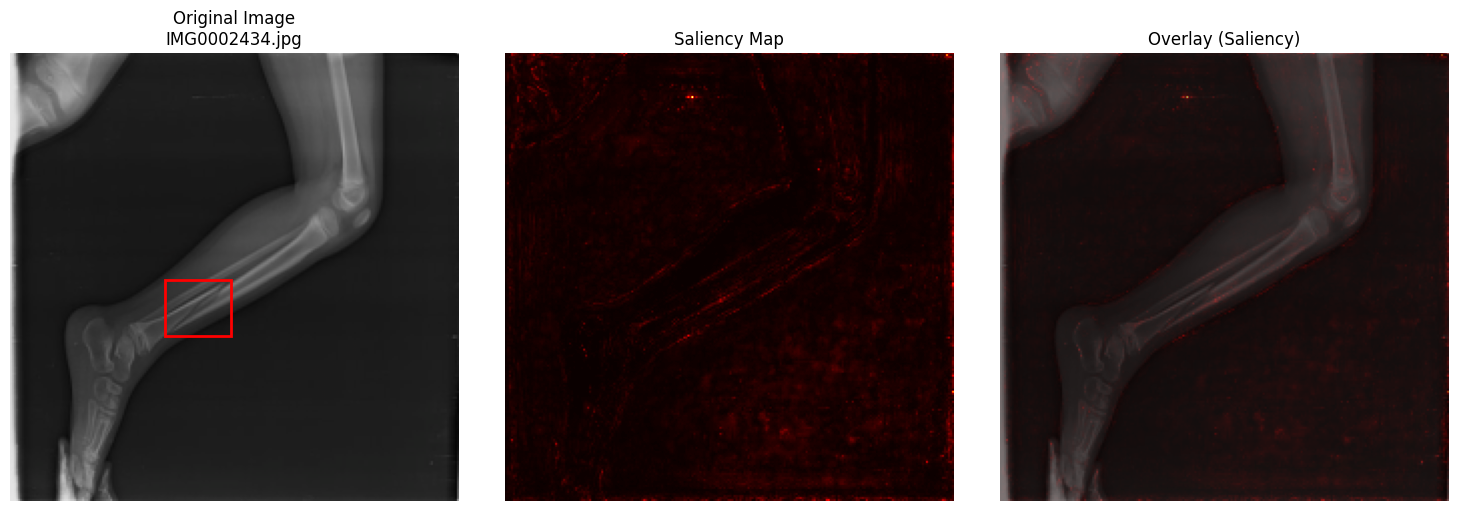

In [76]:
show_attribution_with_box(model, dataset, idx=290, method='saliency')

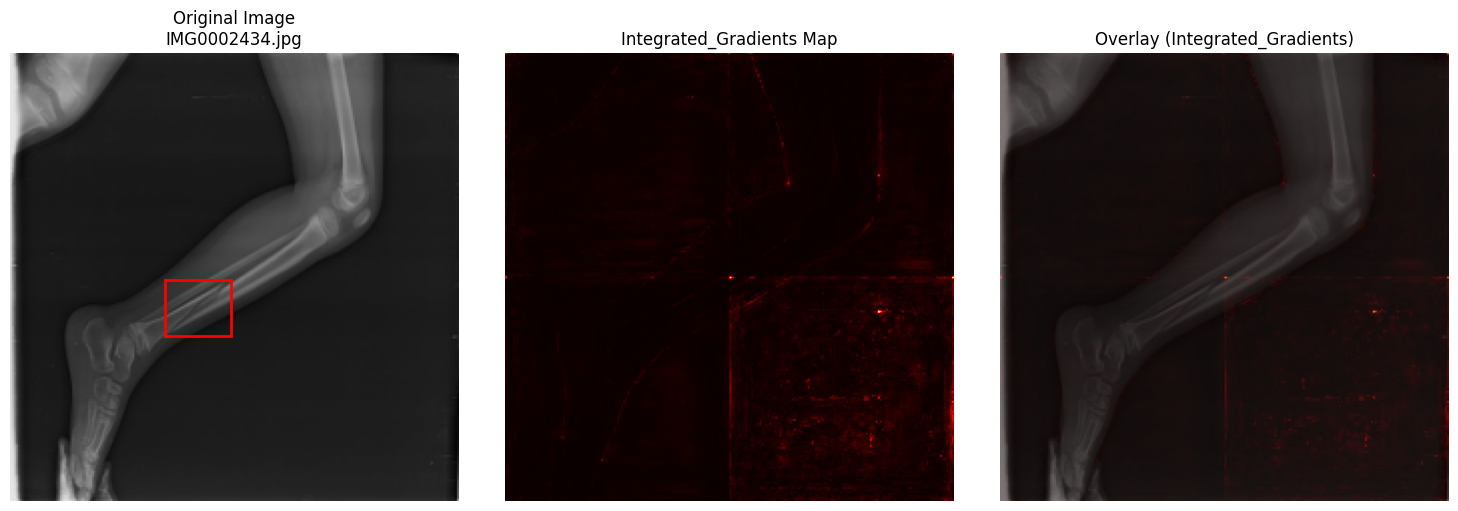

In [77]:
show_attribution_with_box(model, dataset, idx=290, method='integrated_gradients')

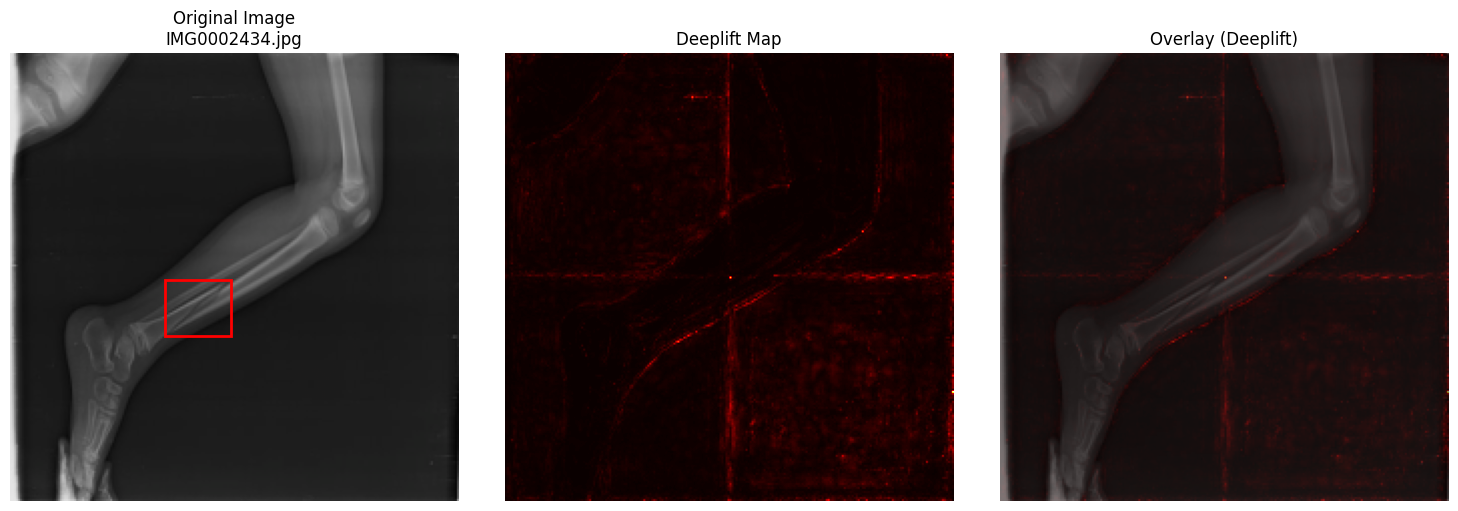

In [78]:
show_attribution_with_box(model, dataset, idx=290, method='deeplift')

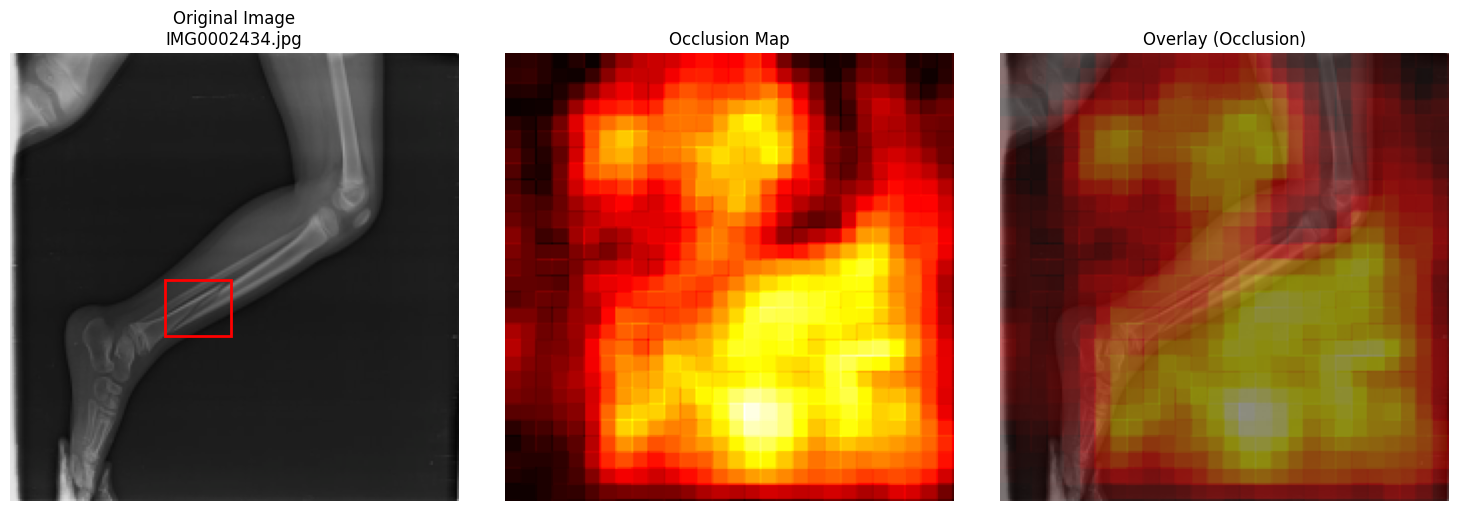

In [79]:
show_attribution_with_box(model, dataset, idx=290, method='occlusion')